In [9]:
import torch

import sys
sys.path.append('..')

from Data import load_and_prepare_dataset_for_layoutLM
from transformers import LayoutLMForTokenClassification
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType 
from Training import fine_tune_model, evaluate_model
from utils.utils import load_trained_lora_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
id2label, label2id, train_dataloader, val_dataloader, test_dataloader = load_and_prepare_dataset_for_layoutLM(batch_size=2)

Map: 100%|██████████| 45/45 [00:00<00:00, 59.81 examples/s]


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Study on varying r (lora dimension)

In [ ]:
import pickle
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup

# Values for r and lora_alpha
r_values = [4, 8, 16, 32, 64]
# NOTE: 'We then scale ∆W x by α/r, where α is a constant in r' (from the paper)
lora_alpha_normalized = 8

NUM_EXPERIMENTS = 20
results_list = []

for _ in range(NUM_EXPERIMENTS):
    # Store results, losses and metrics for each model
    results_dict = {}
    for r in r_values:
        
        training_losses_list, val_losses_list, training_f1s_list, val_f1s_list, training_accs_list, val_accs_list = [], [], [], [], [], []

        print("######## Training with r={} and lora_alpha={} ########".format(r, lora_alpha_normalized))
        lora_alpha = lora_alpha_normalized * r
        # Configure model
        model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id)
        peft_config = LoraConfig(
            task_type=TaskType.TOKEN_CLS, inference_mode=False, r=r, lora_alpha=lora_alpha
        )
        model = get_peft_model(model, peft_config)
        nb_params = count_trainable_params(model)
        optimizer = AdamW(params=model.parameters(),
                        lr=5e-4)
        scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=2, num_training_steps=30)

        training_losses, val_losses, training_f1s, val_f1s, training_accs, val_accs = fine_tune_model(
            model=model,
            device=device,
            optimizer=optimizer,
            scheduler=scheduler,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            id2label=id2label,
            num_epoch_max=20,
            early_stopping=False,
            test_frequency=1,
            model_folder='Lora_Fine_Tuning',
            model_name=f'Lora_r_{r}_alpha_8'
        )
        training_losses_list.append(training_losses)
        val_losses_list.append(val_losses)
        training_f1s_list.append(training_f1s)
        val_f1s_list.append(val_f1s)
        training_accs_list.append(training_accs)
        val_accs_list.append(val_accs)

        model = load_trained_lora_model(id2label=id2label, label2id=label2id, r=r, path=f'../Saved_Models/Lora_Fine_Tuning/Best_Lora_r_{r}_alpha_{lora_alpha_normalized}.pth')
        
        results = evaluate_model(
            model=model,
            device=device,
            test_dataloader=test_dataloader,
            original_id2label=id2label
        )

        results['training_losses_list'] =  training_losses_list
        results['val_losses_list'] =  val_losses_list
        results['training_f1s_list'] =  training_f1s_list
        results['val_f1s_list'] =  val_f1s_list
        results['training_accs_list'] =  training_accs_list
        results['val_accs_list'] =  val_accs_list
        results['trainable_parameters'] = nb_params

        results_dict[r] = results
        print('\n')

    results_list.append(results_dict)
    with open('results_list_lora_r_experiment.pkl', 'wb') as f:
        pickle.dump(results_list, f)

In [14]:
# Concatenate with pre-existing result-list
try:
    with open('results_list_lora_r_experiment_all.pkl', 'rb') as f:
        all_results_list = pickle.load(f)
except:
    all_results_list = []

with open('results_list_lora_r_experiment.pkl', 'rb') as f:
        all_results_list.extend(pickle.load(f))

with open('results_list_lora_r_experiment_all.pkl', 'wb') as f:
        pickle.dump(all_results_list, f)

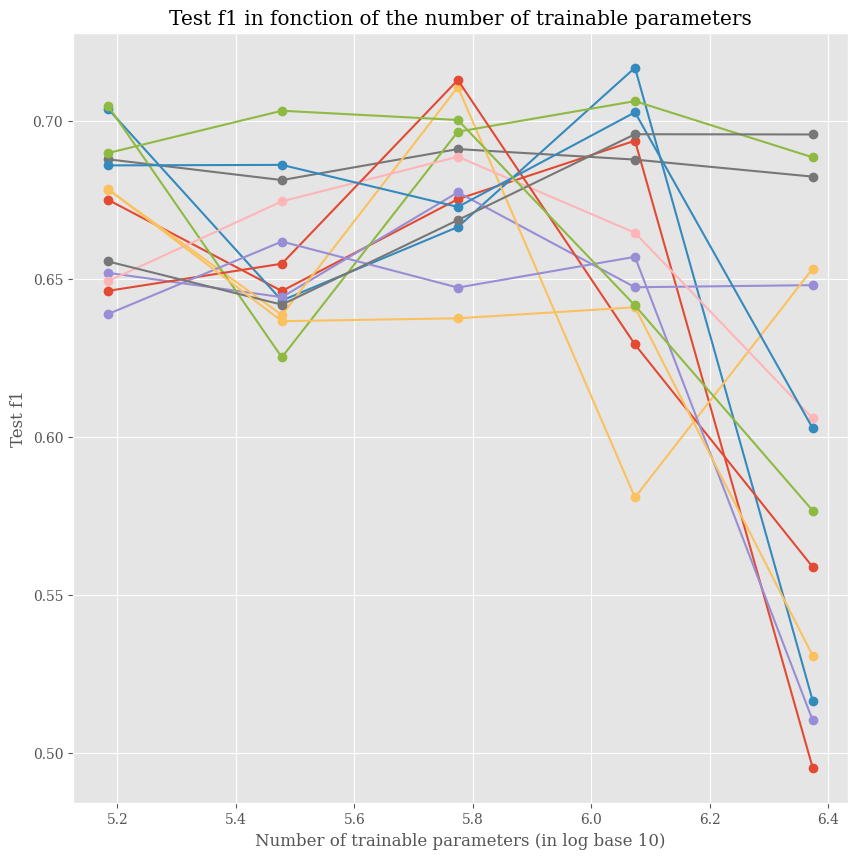

In [28]:
import matplotlib.pyplot as plt
import numpy as np

#results_dict = all_results_list[-1]

plt.figure(figsize=(10, 10))
plt.title("Test f1 in fonction of the number of trainable parameters")
plt.xlabel("Number of trainable parameters (in log base 10)")
plt.ylabel("Test f1")
plt.plot([np.log10(results_dict[r]['trainable_parameters']) for r in results_dict.keys()], [[results_dict[r]['f1'] for results_dict in all_results_list] for r in results_dict.keys() ], 'o-')
plt.show()



### Let's look at an individual example

In [29]:
result_dict = {}

for d in all_results_list:
    for key, value in d.items():
        result_dict.setdefault(key, []).append(value)

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

NUM_EXPERIMENTS = len(all_results_list)

def aggregate_line_results(metric_list, num_experiments = NUM_EXPERIMENTS):

    # My lists may not have the same length due to early stopping
    max_length = max(len(sublist) for sublist in metric_list)

    x_values = np.linspace(1, max_length, max_length)
    results = np.array([sublist + [np.nan] * (max_length - len(sublist)) for sublist in metric_list])

    # Calculate mean and standard deviation for each x-value
    mean_curve = np.mean(results, axis=0)
    std_curve = np.std(results, axis=0, ddof=1)  # ddof=1 for sample standard deviation

    # Calculate confidence interval at 90% level
    confidence_interval_upper = mean_curve + 1.96 * std_curve / np.sqrt(num_experiments)
    confidence_interval_lower = mean_curve - 1.96 * std_curve / np.sqrt(num_experiments)

    return x_values, mean_curve, confidence_interval_lower, confidence_interval_upper


def plot_line_results(ax: plt.Axes, plot_data_and_kwargs, fill_between = True):
    """
    plot_data_and_kwargs: List of tuples.
        Each tuple being of the form (x_values, mean_curve, conf_interval_lower, conf_interval_upper, label)
    """

    for tuple_data_and_kwargs in plot_data_and_kwargs:
        x_values, mean_curve, confidence_interval_lower, confidence_interval_upper, label = tuple_data_and_kwargs

        # Plot the first mean curve
        ax.plot(x_values, mean_curve, label=label)

        # Plot the confidence interval as a shaded region
        if fill_between:
            ax.fill_between(x_values, confidence_interval_lower, confidence_interval_upper, alpha=0.3)

    ax.legend()

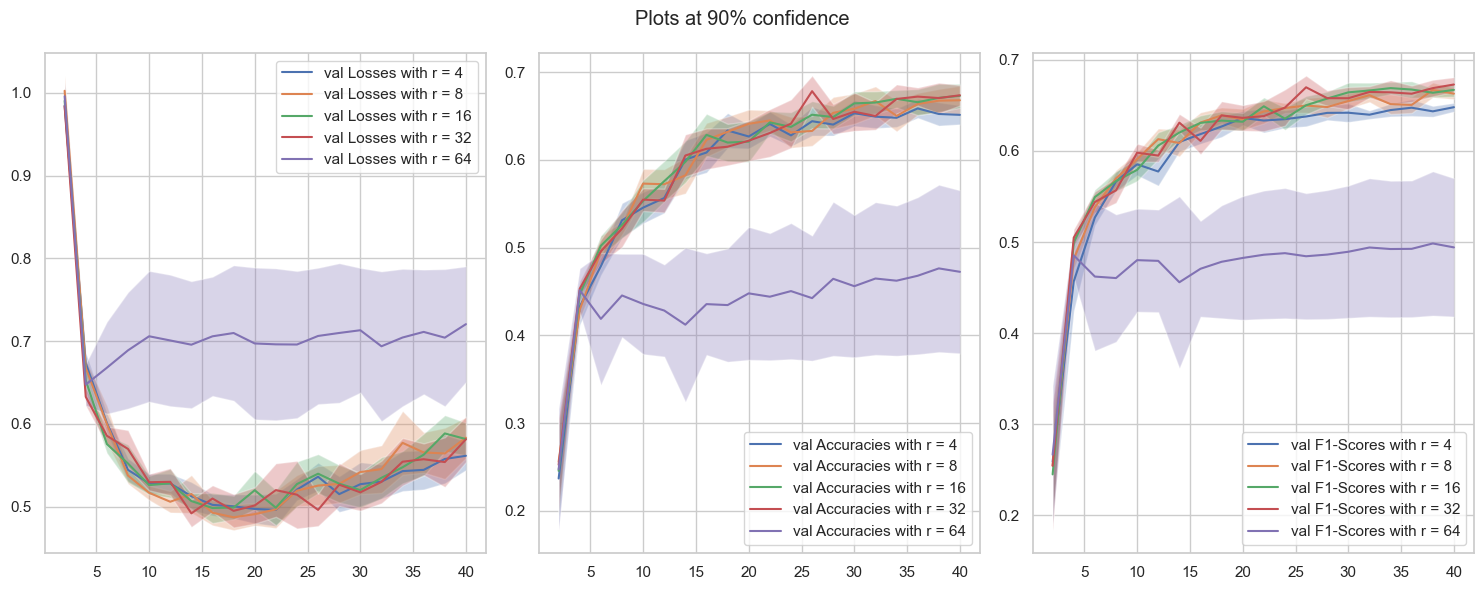

In [31]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

plot_data_and_kwargs_loss = []
plot_data_and_kwargs_accs = []
plot_data_and_kwargs_f1s = []

for key in result_dict.keys():
    val_losses_list = [result_dict[key][i]['val_losses_list'][0] for i in range(len(result_dict[key]))]
    val_accs_list = [result_dict[key][i]['val_accs_list'][0] for i in range(len(result_dict[key]))]
    val_f1s_list = [result_dict[key][i]['val_f1s_list'][0] for i in range(len(result_dict[key]))]

    # Loss plot
    x_values_loss, mean_curve_loss, ci_lower_loss, ci_upper_loss = aggregate_line_results(val_losses_list)
    x_values_loss = 2 * x_values_loss
    plot_data_and_kwargs_loss.append((x_values_loss, mean_curve_loss, ci_lower_loss, ci_upper_loss, f'val Losses with r = {key}'))

    # Accuracy plot
    x_values_accs, mean_curve_accs, ci_lower_accs, ci_upper_accs = aggregate_line_results(val_accs_list)
    x_values_accs = 2 * x_values_accs
    plot_data_and_kwargs_accs.append((x_values_accs, mean_curve_accs, ci_lower_accs, ci_upper_accs, f'val Accuracies with r = {key}'))

    # F1-score plot
    x_values_f1s, mean_curve_f1s, ci_lower_f1s, ci_upper_f1s = aggregate_line_results(val_f1s_list)
    x_values_f1s = 2 * x_values_f1s
    plot_data_and_kwargs_f1s.append((x_values_f1s, mean_curve_f1s, ci_lower_f1s, ci_upper_f1s, f'val F1-Scores with r = {key}'))


plot_line_results(axs[0], plot_data_and_kwargs_loss)
plot_line_results(axs[1], plot_data_and_kwargs_accs)
plot_line_results(axs[2], plot_data_and_kwargs_f1s)

fig.suptitle('Plots at 90% confidence')

plt.tight_layout()
plt.show()

<Axes: >

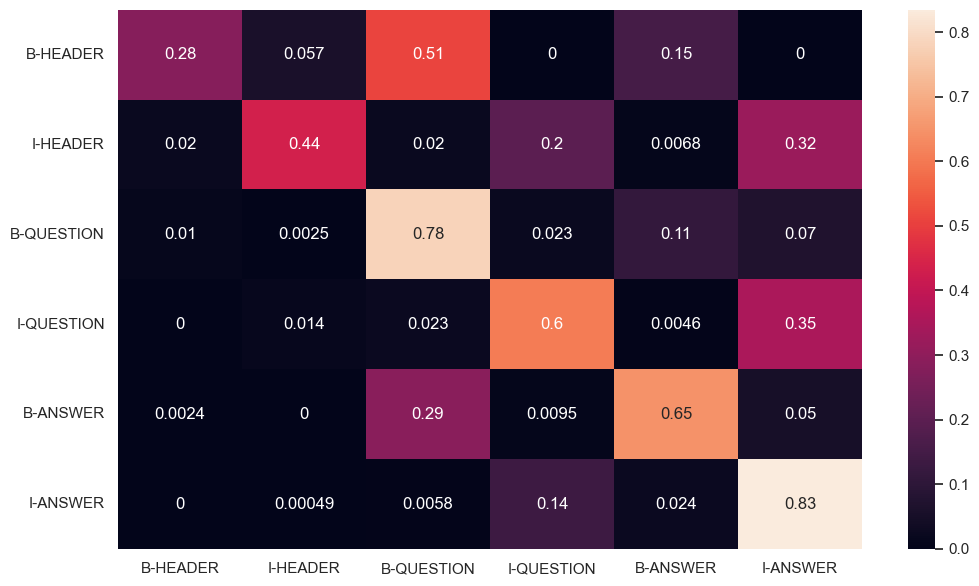

In [32]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize = (12,7))
sn.heatmap(result_dict[4][0]['conf_matrix_tokens'], annot=True)

<Axes: >

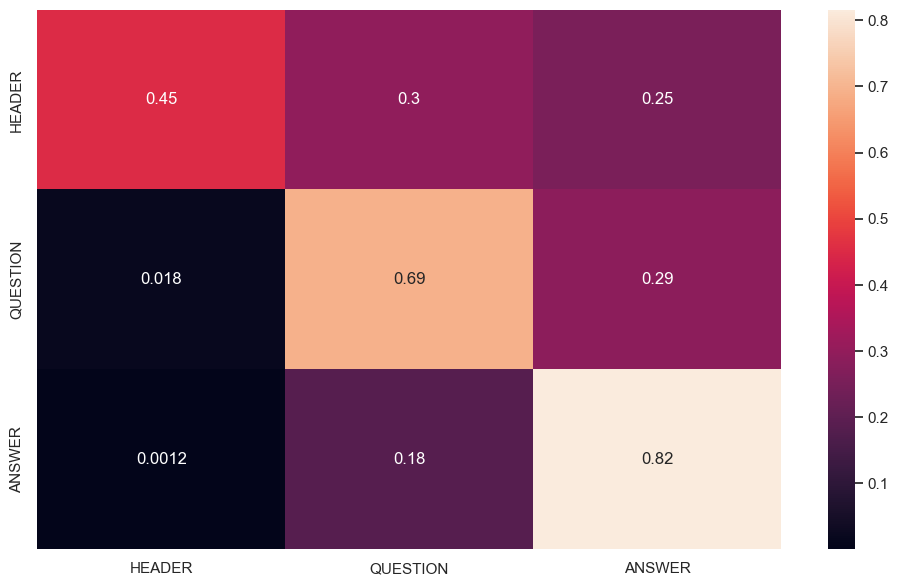

In [33]:
plt.figure(figsize = (12,7))
sn.heatmap(result_dict[4][0]['conf_matrix_words'], annot=True)

### Let's recap performances in a DataFrame

In [34]:
import numpy as np

def aggregate_metrics_results(metrics_arrays_list, total_reduction: bool = False):
    """
    total_reduction: If for an array of shape (M, N, K) we want the mean to output an array of
        shape (K) and not (N, K) (the mean over all labels instead of label wise in or case)
    """

    if total_reduction:
        axis_kwarg = (0, 1)
    else:
        axis_kwarg = 0
    # Convert the list of arrays to a NumPy array
    arrays_array = np.array(metrics_arrays_list)

    # Calculate the mean and standard deviation
    mean_array = np.mean(arrays_array, axis=axis_kwarg)
    std_dev_array = np.std(arrays_array, axis=axis_kwarg, ddof=1)
    quantile_05 = np.percentile(arrays_array, q=5, axis=axis_kwarg)
    quantile_95 = np.percentile(arrays_array, q=95, axis=axis_kwarg)

    if total_reduction:
        mean_array = mean_array[np.newaxis]
        std_dev_array = std_dev_array[np.newaxis]
        quantile_05 = quantile_05[np.newaxis]
        quantile_95 = quantile_95[np.newaxis]

    new_array = np.empty(mean_array.shape, dtype='U16')
    new_array_min_max = np.empty(mean_array.shape, dtype='U16')

    for i in range(new_array.shape[0]):
        for j in range(new_array.shape[1]):
            # [NOTE]: This is under the assumption that it follows a gaussian distribution
            # new_array[i, j] = str(round(mean_array[i, j], 3)) + ' \u00B1 ' + str(round(1.96 * std_dev_array[i, j], 3))
            # We will rather use the empirical quantiles
            new_array[i, j] = str(round(mean_array[i, j], 3)) + ' \u00B1 ' + str(round((quantile_95[i, j] - quantile_05[i, j]) / 2, 3))
            new_array_min_max[i, j] = '(' + str(round(quantile_05[i, j], 3)) + ' ,' + str(round(quantile_95[i, j], 3)) + ')'

    return new_array, new_array_min_max

In [35]:
import pandas as pd

for key_r in result_dict.keys():
    globals()['globals_' + str(key_r)] = pd.DataFrame(data = [['', '', '']], columns=['precision', 'recall', 'f1'], index=[key_r])
    globals()['globals_' + str(key_r) + '_min_max'] = pd.DataFrame(data = [['', '', '']], columns=['precision', 'recall', 'f1'], index=[key_r])
    for key in ['precision', 'recall', 'f1']:
        globals()[f'mean_{key}'] = np.mean([d[key] for d in result_dict[key_r]])
        globals()[f'min_{key}'] = np.min([d[key] for d in result_dict[key_r]])
        globals()[f'max_{key}'] = np.max([d[key] for d in result_dict[key_r]])
        globals()['globals_' + str(key_r)].loc[key_r, key] = globals()[f'mean_{key}']
        globals()['globals_' + str(key_r) + '_min_max'].loc[key_r, key] = (globals()[f'min_{key}'], globals()[f'max_{key}'])
    #globals()['globals_' + key] = pd.concat([globals()['globals_' + key], globals()['globals_' + key + '_' + str(key_r)]])
    #globals()['globals_' + key + '_min_max'] = pd.concat([globals()['globals_' + key + '_min_max'], globals()['globals_' + key + '_' + str(key_r) + '_min_max']])

In [36]:
pd.concat([globals()[f'globals_{key_r}'] for key_r in result_dict.keys()])

,precision,recall,f1
4,0.654503,0.692771,0.672645
8,0.648486,0.667785,0.656637
16,0.65667,0.707856,0.680325
32,0.656356,0.679433,0.66642
64,0.541701,0.672968,0.597215


### Let's visualize an image example

In [40]:
from Data import visualize_sample

In [41]:
sample = next(iter(test_dataloader))

In [42]:
img_true = visualize_sample(sample=sample, id2label=id2label, source='dataset')

In [43]:
import numpy as np

model.eval()
model.to(device)
outputs = model(
    input_ids=sample["input_ids"].to(device),
    bbox=sample["bboxes"].to(device),
    attention_mask=sample["attention_mask"].to(device),
    token_type_ids=sample["token_type_ids"].to(device),
)
logits = outputs.logits
preds = logits.detach().cpu().numpy()
preds = np.argmax(preds, axis=2)

sample["predicted_tags"] = preds

In [44]:
img_pred = visualize_sample(sample=sample, id2label=id2label, source='inference')

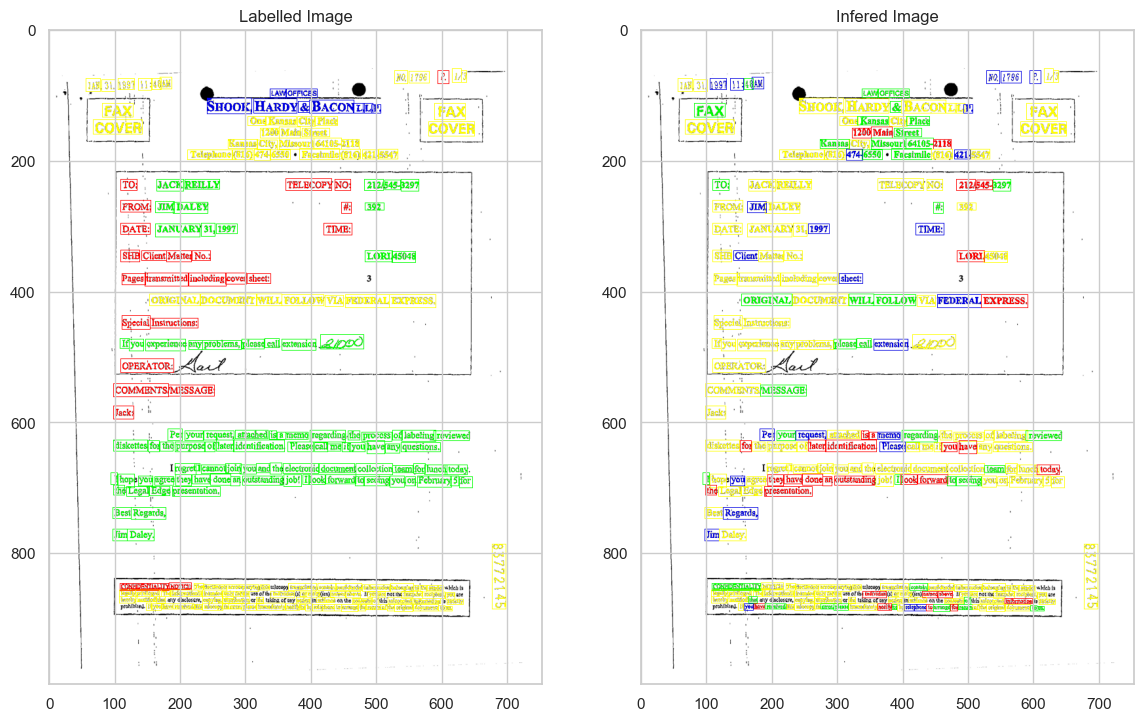

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(14,14))
ax[0].imshow(img_true)
ax[0].set_title('Labelled Image')
ax[1].imshow(img_pred)
ax[1].set_title('Infered Image')
plt.show()

# Color Code: label_to_color = {"question": RED, "answer": GREEN, "header": BLUE, "o": YELLOW}